In [35]:
import requests
import time
import calendar
import dateutil.parser as parser
from dateutil.relativedelta import relativedelta
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import warnings
import yaml
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from pycaret.datasets import get_data
from pycaret.classification import *

### Get Candlestick Data

In [ ]:
now = datetime.now()

In [ ]:
def convert_date(utc_time): 
    parsed_date = parser.parse(utc_time)
    var_date=parsed_date.date()
    var_time=parsed_date.time()
    var_f_time=var_time.hour
    var_julian_date=parsed_date.timetuple().tm_yday
    var_weekday=parsed_date.weekday()
    var_weekday_name=calendar.day_name[parsed_date.weekday()]
    return var_date, var_time, var_f_time, var_julian_date, var_weekday, var_weekday_name

In [ ]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    instrument = cfg['currency']['instrument']

In [ ]:
print('Instrument:', instrument)

In [ ]:
with open ('config.yml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    oanda_api_key = cfg['creds']['oanda_api']
    account_number = cfg['creds']['account_number'] 

In [ ]:
Load_10K_Records=True
Load_20K_Records=True

#  'EUR_USD','USD_CAD','EUR_GBP','EUR_AUD','EUR_CHF',
#  'GBP_USD','GBP_CHF','GBP_NZD','GBP_AUD','GBP_CAD',
#  'AUD_CAD','AUD_CHF','AUD_NZD','NZD_USD','EUR_CAD',
#  'USD_CHF','CAD_CHF','NZD_CAD','AUD_USD','EUR_NZD',
#  'NZD_CHF',

currency_pairs = [instrument]


timeframe = "H4"
#D #H1 #H4 M30
# https://developer.oanda.com/rest-live-v20/instrument-df/#CandlestickGranularity
price_char = "M"
#M(midpoint candles) #B(bid candles) #A(ask candles) #BA
price_com = "mid"
#mid #bid #ask

# def of OANDA request variable
provider_api_url = 'https://api-fxpractice.oanda.com/v3/accounts/{}/orders'.format(account_number)
request_headers = {
    "Authorization": oanda_api_key,
    "Accept-Datetime-Format": "RFC3339",
    "Connection": "Keep-Alive",
    "Content-Type": "application/json;charset=UTF-8"
}


In [ ]:
provider_authorization = 'Bearer {0}'.format(oanda_api_key)

headers = {
    'Content-Type': 'application/json',
    'Authorization': provider_authorization,
}

In [ ]:
params_count = (
    ('price', price_char),
    ('count', '5000'),
    ('granularity', timeframe),
)


In [ ]:
for pair in currency_pairs:
    first_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair), 
                            headers=headers,
                            params=params_count).json()

In [ ]:
if Load_10K_Records:
    
    #### Load 10K data
        
    datetime_object = parser.parse(first_response['candles'][0]['time'])
    date= datetime_object - relativedelta(years=3)  
    from_date = date.replace(tzinfo=timezone.utc).timestamp()
    params_date = (
        ('count', '5000'),
        ('price', price_char),
        ('from', from_date),
        ('granularity', timeframe),)

    second_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                   headers=headers,
                                   params=params_date).json()
    datetime_object_15K = parser.parse(second_response['candles'][0]['time'])
    first_response= first_response['candles']  
    second_response= second_response['candles']
    second_response.extend(first_response)
    
    if Load_20K_Records:

        #### Load 15K data

        date= datetime_object_15K - relativedelta(years=3)  
        from_date = date.replace(tzinfo=timezone.utc).timestamp()
        params_date = (
            ('count', '5000'),
            ('price', price_char),
            ('from', from_date),
            ('granularity', timeframe),)

        third_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                       headers=headers,
                                       params=params_date).json()
        datetime_object_20K = parser.parse(third_response['candles'][0]['time'])
        third_response= third_response['candles']
        third_response.extend(second_response)

        #### Load 20K data

        date= datetime_object_20K - relativedelta(years=3)  
        from_date = date.replace(tzinfo=timezone.utc).timestamp()
        params_date = (
            ('count', '5000'),
            ('price', price_char),
            ('from', from_date),
            ('granularity', timeframe),)

        fourth_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                       headers=headers,
                                       params=params_date).json()
        datetime_object_20K = parser.parse(fourth_response['candles'][0]['time'])
        fourth_response= fourth_response['candles']
        fourth_response.extend(third_response)

        response=fourth_response
    else:
       response=second_response 
else:
    response=first_response['candles']

In [ ]:
filename = "{}_{}.csv".format(pair, timeframe)
output = []
all_candlesticks = response

for i in range (len(all_candlesticks)):
    result= (convert_date(response[i]['time']))
    output.append([(result[0]),(result[1]),(result[2]),(result[3]),(result[4]),(result[5]),
                    response[i]['time'],
                    response[i]['volume'], 
                    response[i][price_com]['o'],
                    response[i][price_com]['h'],
                    response[i][price_com]['l'],
                    response[i][price_com]['c']])
    
output = pd.DataFrame(output)
output.columns = ['Date','Time','f_time','julian_date','Weekday','Weekday_Name','UTC_Time', 'Volume', 'Open', 'High', 'Low', 'Close']
data = output.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [ ]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [ ]:
data.shape

In [ ]:
data.head(5)

In [ ]:
data.tail(5)

In [ ]:
data['SMA_5'] = data['Close'].rolling(window=5).mean().round(4)
data['SMA_10'] = data['Close'].rolling(window=10).mean().round(4)
data['SMA_20'] = data['Close'].rolling(window=20).mean().round(4)

In [ ]:
data['F_SMA_5'] = data['Close'] - data['SMA_5']
data['F_SMA_10'] = data['Close'] - data['SMA_10']
data['F_SMA_20'] = data['Close'] - data['SMA_20']

In [ ]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [ ]:
data.tail()

In [ ]:
data['O-H'] = data['Open'] - data['High']
data['O-L'] = data['Open'] - data['Low']
data['O-C'] = data['Open'] - data['Close']
data['H-L'] = data['High'] - data['Low']
data['H-C'] = data['High'] - data['Close']
data['L-C'] = data['Low'] - data['Close']

data['Direction'] = data['O-C'].apply(lambda x: 1 if x<0 else 0)

data['col_1'] = data['Open'] - data['Close']

for value in data['col_1']:   
    if value > 0:
        data['col_2'] = data['High'] - data['Open']
        data['col_3'] = data['Close'] - data['Low']
    else:
        data['col_2'] = data['High'] - data['Close']
        data['col_3'] = data['Open'] - data['Low']

#Two Previous Candlesticks 
data['col_4'] = data['col_1'].shift(1)
data['col_5'] = data['col_1'].shift(2)

In [ ]:
data = data.dropna()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [ ]:
data.tail()

In [ ]:
data.shape

### Settings

In [2]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    k_number = cfg['knn']['k_number']
    metric = cfg['knn']['metric']
    algorithm = cfg['knn']['algorithm']
    feature_1 = cfg['knn']['feature_1']
    feature_2 = cfg['knn']['feature_2']
    feature_3 = cfg['knn']['feature_3']
    feature_7 = cfg['knn']['feature_7']
    feature_8 = cfg['knn']['feature_8']   
    volume = cfg['feature']['volume']
    volume_size = cfg['sample']['volume_size']
    sample_count = cfg['sample']['count']
    candles = cfg['recommendation']['candle_count']
    pair = cfg['currency']['pair']
    instrument = cfg['currency']['instrument']

In [3]:
print('K Number:',k_number)
print('Metric:', metric)
print('Algorithm:', algorithm)
print('Candle Volume Size:', volume_size)
print('Random Sample Count:', sample_count)
print('Future Candle Count:', candles)
print('Pair:', pair)
print('Instrument:', instrument)

K Number: 5
Metric: euclidean
Algorithm: brute
Candle Volume Size: 3500
Random Sample Count: 8000
Future Candle Count: 7
Pair: EURGBP
Instrument: EUR_GBP


In [4]:
def convert_date(utc_time): 
    parsed_date = parser.parse(utc_time)
    var_date=parsed_date.date()
    var_time=parsed_date.time()
    var_f_time=var_time.hour
    var_julian_date=parsed_date.timetuple().tm_yday
    var_weekday=parsed_date.weekday()
    var_weekday_name=calendar.day_name[parsed_date.weekday()]
    return var_date, var_time, var_f_time, var_julian_date, var_weekday, var_weekday_name

In [5]:
def find_k_similar_candles(candle_id, dataset, k = k_number):
    indices=[]
    distances = []
    output = []
    model_knn = NearestNeighbors(metric = metric, algorithm = algorithm) 
    model_knn.fit(dataset)
    
    #metric = 'euclidean' or 'cosine' or 'manhattan' or 'mahalanobis'
    
    distances, indices = model_knn.kneighbors(dataset.iloc[candle_id,:].values.reshape(1,-1),
                                              n_neighbors = k)

    for i in range(0,len(distances.flatten())):
        if i!=0:
            
            output.append ([dataset.index[indices.flatten()[i]],
                            distances.flatten()[i],
                            dataset.iloc[indices.flatten()[i]][feature_1],
                            dataset.iloc[indices.flatten()[i]][feature_2],
                            dataset.iloc[indices.flatten()[i]][feature_3],
                            dataset.iloc[indices.flatten()[i]][feature_7],
                            dataset.iloc[indices.flatten()[i]][feature_8],                            
                           ])
    
    output = pd.DataFrame(output)
    output.columns = ['Indice','Distance',
                      feature_1,
                      feature_2,
                      feature_3,
                      feature_7,
                      feature_8,
                     ]
   # display (output)
    
    return indices, distances

# <font color='red'>Test Configs</font>

In [6]:
filename = 'EUR_GBP_H4.csv'
data = pd.read_csv(filename)

In [7]:
data.columns

Index(['Date', 'Time', 'f_time', 'julian_date', 'Weekday', 'Weekday_Name',
       'UTC_Time', 'Volume', 'Open', 'High', 'Low', 'Close', 'SMA_5', 'SMA_10',
       'SMA_20', 'F_SMA_5', 'F_SMA_10', 'F_SMA_20', 'O-H', 'O-L', 'O-C', 'H-L',
       'H-C', 'L-C', 'Direction', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5'],
      dtype='object')

In [8]:
data.shape

(19322, 30)

In [9]:
data.head()

,Date,Time,f_time,julian_date,Weekday,Weekday_Name,UTC_Time,Volume,Open,High,...,O-C,H-L,H-C,L-C,Direction,col_1,col_2,col_3,col_4,col_5
0,2009-11-18,02:00:00,2,322,2,Wednesday,2009-11-18T02:00:00.000000000Z,1765,0.88575,0.88628,...,0.00033,0.00113,0.00086,-0.00027,0,0.00033,0.00086,0.00060,-0.00096,-0.00078
1,2009-11-18,06:00:00,6,322,2,Wednesday,2009-11-18T06:00:00.000000000Z,7531,0.88540,0.89090,...,-0.00294,0.00590,0.00256,-0.00334,1,-0.00294,0.00256,0.00040,0.00033,-0.00096
2,2009-11-18,10:00:00,10,322,2,Wednesday,2009-11-18T10:00:00.000000000Z,6439,0.88832,0.89041,...,-0.00045,0.00237,0.00164,-0.00073,1,-0.00045,0.00164,0.00028,-0.00294,0.00033
3,2009-11-18,14:00:00,14,322,2,Wednesday,2009-11-18T14:00:00.000000000Z,8415,0.88879,0.89493,...,-0.00549,0.00631,0.00065,-0.00566,1,-0.00549,0.00065,0.00017,-0.00045,-0.00294
4,2009-11-18,18:00:00,18,322,2,Wednesday,2009-11-18T18:00:00.000000000Z,3099,0.89426,0.89427,...,0.00090,0.00114,0.00091,-0.00023,0,0.00090,0.00091,0.00113,-0.00549,-0.00045


## Selecting n random candles where their volume is more than 5000

In [10]:
random_samples = data[data[volume] > volume_size].sample(n = sample_count)

In [11]:
#Random_Candles = np.random.randint(low=1, high=len(data)-40, size=1000)
Random_Candles = list(random_samples.index.values)

In [12]:
#show the fisrt 10 random generated candle numbers
Random_Candles[0:10]

[7570, 6861, 18520, 14285, 12888, 9136, 14718, 14621, 14417, 2466]

# <font color='red'>CANDLE LOOP</font>

In [13]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [14]:
%%time
print ('Today: ' + today)

result_output = pd.DataFrame({'Candle_No':[],
                              'Current_Market_Fit':[],
                              'Current_Market':[],
                              'Rec1_Score':[],
                              'Rec1_Prediction':[],
                              'Rec2_Score':[],
                              'Rec2_Prediction':[],
                              'Rec3_Score':[],
                              'Rec3_Prediction':[],
                              'Rec4_Score':[],
                              'Rec4_Prediction':[]
                             })

for candle_no in Random_Candles:
    data = pd.read_csv(filename)
    data = data.iloc[candle_no:candle_no+candles]
    data['candleno'] = range (1, len(data) + 1)
    X = data['candleno'].values.reshape(-1, 1)
    Y = data['Close'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y_pred = linear_regressor.predict(X) 
    
    Current_Market_Fit = r2_score(Y, y_pred)*100
    #print(Current_Market_Fit)
    coeficient = (linear_regressor.coef_)

    if coeficient > 0:
        Current_Market='Bullish'
    else:
        Current_Market = 'Bearish'
    
    data = pd.read_csv(filename)
    data = data[[feature_1,
                 feature_2,
                 feature_3,
                 feature_7,
                 feature_8,
                ]]

    indices, distances = find_k_similar_candles (candle_no,data)
    indices = indices[0:1][0]
    
    predicted_output = []
    recs = []
    for indice in indices[1:5]:
             
        Predicted_Market_Fit =0
        Predicted_Trade=''
    
        data = pd.read_csv(filename) 
        data = data.iloc[indice:indice+candles]

        data['candleno'] = range (1, len(data) + 1)
        X = data['candleno'].values.reshape(-1, 1)
        Y = data['Close'].values.reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        y_pred = linear_regressor.predict(X)

        Predicted_Market_Fit= r2_score(Y, y_pred)*100
        coeficient = (linear_regressor.coef_)

        if coeficient > 0:
            Predicted_Trade= 'BUY'
        else:
            Predicted_Trade = 'SELL'
        
        predicted_output.append([Predicted_Market_Fit,Predicted_Trade])
        
    result = {'Candle_No': candle_no,
              'Current_Market_Fit': Current_Market_Fit,
              'Current_Market': Current_Market,
              'Rec1_Score': predicted_output[0][0],
              'Rec1_Prediction': predicted_output[0][1],
              'Rec2_Score': predicted_output[1][0],
              'Rec2_Prediction': predicted_output[1][1],
              'Rec3_Score': predicted_output[2][0],
              'Rec3_Prediction': predicted_output[2][1],
              'Rec4_Score': predicted_output[3][0],
              'Rec4_Prediction': predicted_output[3][1],
             }
    
    result_output = result_output.append(result, ignore_index = True)

Today: 31-01-2022_02-58_AM
CPU times: user 6h 28min 3s, sys: 8h 49min 5s, total: 15h 17min 8s
Wall time: 1h 25min 10s


In [15]:
result_output.to_csv('01_Back_Test_Data.csv', header = True, index = False)
result_output.to_csv(today + "_" + "Back_Test_Data_" + pair + '.csv', header = True, index = False)
result_output = pd.read_csv(today + "_" + "Back_Test_Data_" + pair + '.csv')
result_output.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,7570.0,42.497542,Bullish,17.024606,SELL,0.711886,BUY,72.750970,BUY,81.216341,BUY
1,6861.0,45.190427,Bearish,6.384803,BUY,49.375808,SELL,46.369185,SELL,59.725228,SELL
2,18520.0,56.846442,Bearish,1.492243,SELL,12.574536,SELL,96.281050,BUY,47.654609,SELL
3,14285.0,66.497917,Bearish,29.939422,SELL,56.398739,BUY,94.748542,BUY,0.095192,SELL
4,12888.0,15.508673,Bearish,17.860350,SELL,59.043303,BUY,83.524843,BUY,29.872423,BUY


In [16]:
result_output.shape

(8000, 11)

#### Generating Log File

In [17]:
file = open(today + "_" + "data_generation_log_" + pair + '.txt', "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "K_Number: " + str(k_number) + "\n" + \
            "KNN_Metric: " + metric + "\n" + \
            "KNN_Algorithm: " + algorithm + "\n" + \
            "Feature: " + feature_1 + "\n" + \
            "Feature: " + feature_2 + "\n" + \
            "Feature: " + feature_3 + "\n" + \
            "Feature: " + feature_7 + "\n" + \
            "Feature: " + feature_8 + "\n" + \
            "Volume Size: " + str(volume_size) + "\n" + \
            "Sample Count: " + str(sample_count) + "\n" + \
            "Candle Counts: " + str(candles) + "\n"
           )
file.close()

In [18]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    pair = cfg['currency']['pair']
    frac = cfg['model']['frac']
    random_state = cfg['model']['random_state']

In [19]:
print('Pair:', pair)
print('Fraction:', frac)
print('Random State:', random_state)

Pair: EURGBP
Fraction: 0.7
Random State: 705


In [20]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [21]:
dataset = pd.read_csv('01_Back_Test_Data.csv')
dataset.shape

(8000, 11)

In [22]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,7570.0,42.497542,Bullish,17.024606,SELL,0.711886,BUY,72.750970,BUY,81.216341,BUY
1,6861.0,45.190427,Bearish,6.384803,BUY,49.375808,SELL,46.369185,SELL,59.725228,SELL
2,18520.0,56.846442,Bearish,1.492243,SELL,12.574536,SELL,96.281050,BUY,47.654609,SELL
3,14285.0,66.497917,Bearish,29.939422,SELL,56.398739,BUY,94.748542,BUY,0.095192,SELL
4,12888.0,15.508673,Bearish,17.860350,SELL,59.043303,BUY,83.524843,BUY,29.872423,BUY


In [23]:
dataset = dataset[dataset['Current_Market_Fit'] > 20]
dataset = dataset.reset_index()
del dataset['index']

In [24]:
dataset.shape

(5689, 11)

In [25]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_Prediction'] = dataset['Rec1_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_Prediction'] = dataset['Rec2_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_Prediction'] = dataset['Rec3_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec4_Prediction'] = dataset['Rec4_Prediction'].replace(['BUY','SELL'],[1,-1])

In [26]:
dataset['Rec1_Score'] = dataset['Rec1_Score'] * dataset['Rec1_Prediction']
dataset['Rec2_Score'] = dataset['Rec2_Score'] * dataset['Rec2_Prediction']
dataset['Rec3_Score'] = dataset['Rec3_Score'] * dataset['Rec3_Prediction']
dataset['Rec4_Score'] = dataset['Rec4_Score'] * dataset['Rec4_Prediction']

In [27]:
dataset['Rec1_Score'] = dataset['Rec1_Score'].round(2)
dataset['Rec2_Score'] = dataset['Rec2_Score'].round(2)
dataset['Rec3_Score'] = dataset['Rec3_Score'].round(2)
dataset['Rec4_Score'] = dataset['Rec4_Score'].round(2)

In [28]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Rec1_Prediction',
    'Rec2_Prediction',
    'Rec3_Prediction',
    'Rec4_Prediction',
], axis=1)

In [29]:
dataset.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,-17.02,0.71,72.75,81.22
1,0,6.38,-49.38,-46.37,-59.73
2,0,-1.49,-12.57,96.28,-47.65
3,0,-29.94,56.40,94.75,-0.10
4,0,-0.01,-0.00,3.43,-34.22


In [31]:
data = dataset.sample(frac=frac, random_state=random_state).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))
print('Fraction: ' + str(frac))
#print('Random State: ', str(random_state))

Data for Modeling: (3982, 5)
Unseen Data For Predictions: (1707, 5)
Fraction: 0.7


In [32]:
data_unseen.shape

(1707, 5)

In [33]:
data_unseen.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,-80.77,60.82,8.09,66.94
1,1,24.02,-71.04,-42.81,91.72
2,1,0.81,-18.72,-61.86,-1.81
3,0,27.56,-2.97,72.90,42.53
4,1,47.82,57.12,-56.38,-15.86


In [36]:
exp_name = setup(data = data,
                 target = 'Current_Market',
#                 fold_shuffle=True,
                 session_id=123,
                 silent=True,
#                 n_jobs = 64,
#                 imputation_type='iterative'
                ) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(3982, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [37]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.5116,0.5099,0.5404,0.5167,0.5279,0.0226,0.0227,0.1890
svm,SVM - Linear Kernel,0.5081,0.0000,0.5149,0.5135,0.5137,0.0159,0.0160,0.1720
lightgbm,Light Gradient Boosting Machine,0.5059,0.4988,0.5312,0.5113,0.5202,0.0112,0.0113,0.0220
dt,Decision Tree Classifier,0.4995,0.4993,0.5121,0.5056,0.5084,-0.0013,-0.0014,0.1730
et,Extra Trees Classifier,0.4890,0.4854,0.4972,0.4946,0.4952,-0.0221,-0.0221,0.0840
rf,Random Forest Classifier,0.4876,0.4827,0.4887,0.4931,0.4903,-0.0247,-0.0249,0.2400
lr,Logistic Regression,0.4869,0.4910,0.6624,0.4939,0.5650,-0.0305,-0.0317,0.2510
nb,Naive Bayes,0.4869,0.4785,0.6199,0.4934,0.5484,-0.0295,-0.0303,0.1740
ridge,Ridge Classifier,0.4869,0.0000,0.6624,0.4939,0.5650,-0.0305,-0.0317,0.1520
lda,Linear Discriminant Analysis,0.4869,0.4910,0.6624,0.4939,0.5650,-0.0305,-0.0317,0.0060


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [38]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    model = cfg['model']['name']

In [39]:
print('Model Name:', model)

Model Name: knn


In [40]:
MODEL = create_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5161,0.4960,0.5603,0.5197,0.5392,0.0313,0.0314
1,0.5125,0.5038,0.5177,0.5177,0.5177,0.0250,0.0250
2,0.5806,0.5757,0.6241,0.5789,0.6007,0.1605,0.1610
3,0.5197,0.5172,0.5674,0.5229,0.5442,0.0384,0.0386
4,0.4659,0.4635,0.5248,0.4744,0.4983,-0.0695,-0.0699
5,0.5305,0.5397,0.5532,0.5342,0.5436,0.0605,0.0605
6,0.5090,0.5123,0.5248,0.5139,0.5193,0.0176,0.0176
7,0.4928,0.4968,0.5603,0.5000,0.5284,-0.0164,-0.0165
8,0.4748,0.4734,0.4823,0.4823,0.4823,-0.0506,-0.0506
9,0.5144,0.5203,0.4894,0.5227,0.5055,0.0295,0.0295


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


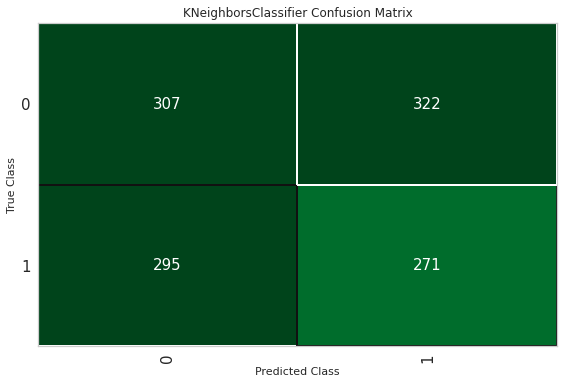

In [41]:
plot_model(MODEL, plot = 'confusion_matrix')

In [42]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4982,0.4845,0.5603,0.5032,0.5302,-0.0049,-0.0050
1,0.4982,0.5053,0.5248,0.5034,0.5139,-0.0042,-0.0042
2,0.5305,0.5095,0.5248,0.5362,0.5305,0.0610,0.0611
3,0.5018,0.4928,0.5745,0.5062,0.5382,0.0020,0.0020
4,0.4982,0.5007,0.5603,0.5032,0.5302,-0.0049,-0.0050
5,0.5233,0.5215,0.5319,0.5282,0.5300,0.0464,0.0464
6,0.5376,0.5272,0.5745,0.5400,0.5567,0.0745,0.0747
7,0.4856,0.4696,0.5390,0.4935,0.5153,-0.0304,-0.0305
8,0.5216,0.4962,0.5177,0.5290,0.5233,0.0433,0.0433
9,0.5324,0.5129,0.5319,0.5396,0.5357,0.0647,0.0648


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


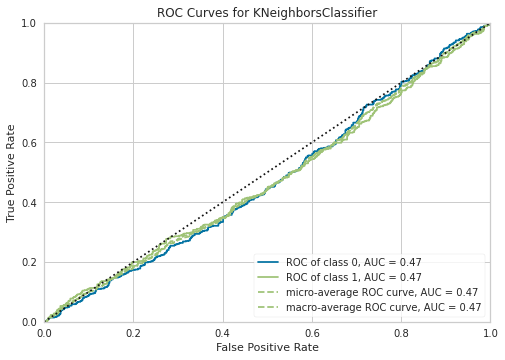

In [43]:
plot_model(TUNED_MODEL, plot = 'auc')

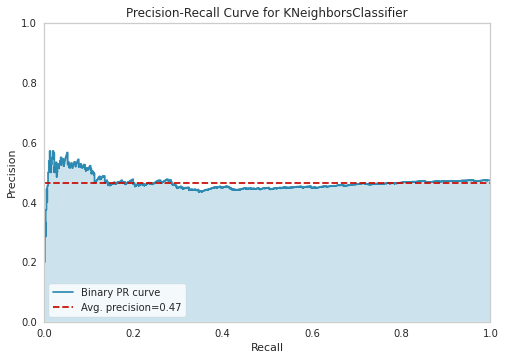

In [44]:
plot_model(TUNED_MODEL, plot = 'pr')

In [45]:
plot_model(TUNED_MODEL, plot='feature')

TypeError: Feature Importance and RFE plots not available for estimators that doesnt support coef_ or feature_importances_ attribute.

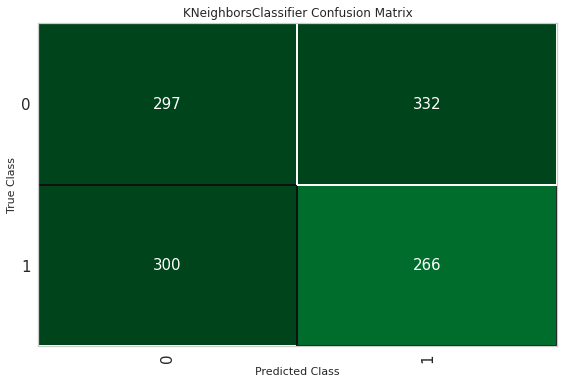

In [46]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [47]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.4711,0.4731,0.4700,0.4448,0.4570,-0.0577,-0.0578


In [48]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [49]:
print(FINAL_MODEL)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='distance')


In [50]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [51]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-80.77,60.82,8.09,66.94,0,0.7484
1,1,24.02,-71.04,-42.81,91.72,1,0.5803
2,1,0.81,-18.72,-61.86,-1.81,1,1.0000
3,0,27.56,-2.97,72.90,42.53,0,1.0000
4,1,47.82,57.12,-56.38,-15.86,1,1.0000


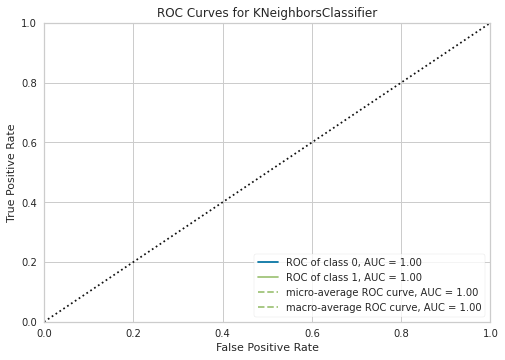

In [52]:
plot_model(FINAL_MODEL, plot = 'auc')

In [53]:
pkl_name = (today + "_" + model + "_" + pair)

In [54]:
save_model(FINAL_MODEL, pkl_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                 ('fix_perfect', Remove_100(target='Current_Market')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'p

In [55]:
SAVED_FINAL_MODEL = load_model(pkl_name)

Transformation Pipeline and Model Successfully Loaded


In [56]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [57]:
data_unseen.shape

(1707, 5)

In [58]:
new_prediction.head(20)

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-80.77,60.82,8.09,66.94,0,0.7484
1,1,24.02,-71.04,-42.81,91.72,1,0.5803
2,1,0.81,-18.72,-61.86,-1.81,1,1.0000
3,0,27.56,-2.97,72.90,42.53,0,1.0000
4,1,47.82,57.12,-56.38,-15.86,1,1.0000
5,0,-7.67,0.99,-14.80,3.48,0,1.0000
6,1,-6.16,59.85,77.76,-6.38,1,0.8140
7,1,72.66,-53.62,31.86,-63.51,1,0.6081
8,1,-52.13,-74.33,-100.00,-37.49,0,0.6257
9,0,-56.15,51.71,79.63,-38.69,0,1.0000


In [59]:
file = open(today + "_" + model + "_binary_classification_log_" + pair + ".txt", "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "Model: " + model + "\n" + \
            "Frac: " + str(frac) + "\n" + \
            "Random State: " + str(random_state) + "\n" )
file.close()

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
